In [1]:
import numpy as np
from sympy import symbols, Matrix, cos, sin, eye, pi, lambdify
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Define Symbols
t1, t2, t3, t4, t5, t6, t7, ti = symbols("\\theta_1 \\theta_2 \\theta_3 \\theta_4 \\theta_5 \\theta_6 \\theta_7 \\theta_i")
d1, d2, d3, d4, d5, d6, d7, di = symbols("d_1 d_2 d_3 d_4 d_5 d_6 d_7 d_i")
a1, a2, a3, a4, a5, a6, a7, ai = symbols("a_1 a_2 a_3 a_4 a_5 a_6 a_7 a_i")
al1, al2, al3, al4, al5, al6, al7, ali = symbols("\\alpha_1 \\alpha_2 \\alpha_3 \\alpha_4 \\alpha_5 \\alpha_6 \\alpha_7 \\alpha_i")

# Define General Transformation Matrix
Rx = Matrix([[1, 0, 0, 0],
             [0, cos(ali), -sin(ali), 0],
             [0, sin(ali), cos(ali), 0],
             [0, 0, 0, 1]])

Dx = Matrix([[1, 0, 0, ai],
             [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

Rz = Matrix([[cos(ti), -sin(ti), 0, 0],
             [sin(ti), cos(ti), 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

Dz = Matrix([[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, di],
             [0, 0, 0, 1]])

T = Dx * Rx * Dz * Rz

L0 = 270.35e-3
L1 = 69e-3
L2 = 364.35e-3
L3 = 69e-3
L4 = 374.29e-3
L5 = 10e-3
L6 = 229.525e-3
L7 = 10e-3

# Define D-H parameters
alpha = Matrix([0,-pi/2, pi/2, -pi/2, pi/2, -pi/2, pi/2])  # radians
theta_left = Matrix([t1, t2+pi/2, t3, t4, t5, t6, t7])  # radians
theta_right = Matrix([t1+pi, t2-pi/2, t3, t4, t5, t6, t7])  # radians
a = Matrix([0,L1,0,L3,0,L5,0])  # m
d = Matrix([L0,0,L2,0,L4,0,L6+L7])  # m
assert len(alpha) == len(theta_left) == len(theta_right) == len(a) == len(d)

# Left arm forward kinematics
T_left = []
Tleft_end = eye(4)
for i in range(len(alpha)):
    T_left.append(T.subs({ali: alpha[i], ai: a[i], di: d[i], ti: theta_left[i]}))
    Tleft_end *= T_left[i] # transformation matrix from base frame to end effector

# Right arm forward kinematics
T_right = []
Tright_end = eye(4)
for i in range(len(alpha)):
    T_right.append(T.subs({ali: alpha[i], ai: a[i], di: d[i], ti: theta_right[i]}))
    Tright_end *= T_right[i] # transformation matrix from base frame to end effector

# convert to numpy equations
forward_kinematics_x_left = lambdify((t1, t2, t3, t4, t5, t6, t7), Tleft_end[0,3], 'numpy') # px
forward_kinematics_y_left = lambdify((t1, t2, t3, t4, t5, t6, t7), Tleft_end[1,3], 'numpy') # py
forward_kinematics_z_left = lambdify((t1, t2, t3, t4, t5, t6, t7), Tleft_end[2,3], 'numpy') # pz
forward_kinematics_x_right = lambdify((t1, t2, t3, t4, t5, t6, t7), Tright_end[0,3], 'numpy')
forward_kinematics_y_right = lambdify((t1, t2, t3, t4, t5, t6, t7), Tright_end[1,3], 'numpy')
forward_kinematics_z_right = lambdify((t1, t2, t3, t4, t5, t6, t7), Tright_end[2,3], 'numpy')

# Define the joint limits (radians)
joint_limits = [(-1.7016, 1.7016), (-2.147, 1.047), (-3.0541, 3.0541), (-0.05, 2.618), (-3.059, 3.059), (-1.5707, 2.094), (-3.059, 3.059)]

In [3]:
# Define joint angle ranges based on joint limits
n_points = 10
t1_range = np.linspace(joint_limits[0][0], joint_limits[0][1], n_points)
t2_range = np.linspace(joint_limits[1][0], joint_limits[1][1], n_points)
t3_range = np.linspace(joint_limits[2][0], joint_limits[2][1], n_points)
t4_range = np.linspace(joint_limits[3][0], joint_limits[3][1], n_points)
t5_range = np.linspace(joint_limits[4][0], joint_limits[4][1], n_points)
t6_range = np.linspace(joint_limits[5][0], joint_limits[5][1], n_points)
t7_range = np.linspace(joint_limits[6][0], joint_limits[6][1], n_points)

# Generate grid of joint angles
t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid = np.meshgrid(t1_range, t2_range, t3_range, t4_range, 
                                                                            t5_range, t6_range, t7_range)

In [4]:
# Calculate end effector positions for left arm
x_left = forward_kinematics_x_left(t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid)
y_left = forward_kinematics_y_left(t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid)
z_left = forward_kinematics_z_left(t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid)

In [5]:
# Calculate end effector positions for right arm
x_right = forward_kinematics_x_right(t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid)
y_right = forward_kinematics_y_right(t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid)
z_right = forward_kinematics_z_right(t1_grid, t2_grid, t3_grid, t4_grid, t5_grid, t6_grid, t7_grid)

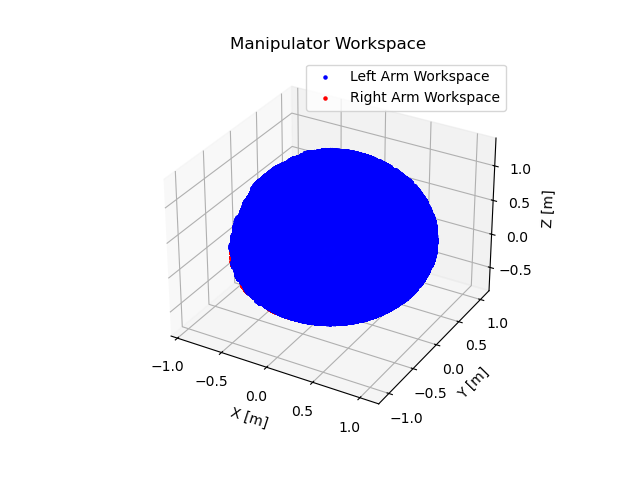

In [6]:
%matplotlib widget

# Plot workspace for left arm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_left.flatten(), y_left.flatten(), z_left.flatten(), c='b', marker='.', label='Left Arm Workspace')

# Plot workspace for right arm
ax.scatter(x_right.flatten(), y_right.flatten(), z_right.flatten(), c='r', marker='.', label='Right Arm Workspace')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()
plt.title('Manipulator Workspace')

plt.show()

In [ ]:
plt.savefig('plot.png')  # Save plot as PNG file